In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
import seaborn as sns

**Data pre-processing**

In [28]:
#Code for creating data frame of testing data
data = pd.read_csv('requests.csv')
data.columns = ['timestamp', 'userID', 'sessionID', 'expiring', 'URL']

In [29]:
#Formatting the data frame so that each row represent one user. 
#All requests are saved as a string in the "URL"-column
users = list(data['userID'])
allUsers = data.set_index(['userID']).rename_axis(None)
allUsers = allUsers.drop(columns=['timestamp', 'sessionID', 'expiring'])
df = allUsers.groupby(level=0).agg(','.join)
df.reset_index(inplace=True)
df = df.rename(columns={'index': 'users'})



In [30]:
#Removing all non-letter characters from the data
request_logs = df['URL']

cleaned_logs = []

for i in range(0, len(request_logs)):
    sequence = re.sub('[^a-zA-Z]', ' ', request_logs[i])
    sequence = sequence.lower()
    cleaned_logs.append(sequence)

df['request_logs'] = cleaned_logs
df = df.drop('URL', axis=1)

# 5 and 6: spammers, 7: data scraper
#print(cleaned_logs[7])

In [31]:
#Using the tfidf-vectorizer
tfidf_vect = TfidfVectorizer()
vect_logs = tfidf_vect.fit_transform(df['request_logs'])

In [8]:
#Code for calculating variance??
arr_values = []
#arr_variance = []

for i in range(0,1):
    for j in range (0, vect_logs.shape[1]):
        #print(vect_logs[i,j])
        val = vect_logs[i,j]
        arr_values.append(val)
        
print(arr_values, '\n')

array = np.array(arr_values)
print(array, '\n')
print(np.var([arr_values]))

[0.04185434270712021, 0.282709348188244, 0.023892541171969546, 0.5665450304893237, 0.08196963306760952, 0.0, 0.13179981976611044, 0.28327251524466185, 0.3389138222557126, 0.0, 0.4716513189096292, 0.0717512204475485, 0.2635996395322209, 0.282709348188244, 0.023892541171969546] 

[0.04185434 0.28270935 0.02389254 0.56654503 0.08196963 0.
 0.13179982 0.28327252 0.33891382 0.         0.47165132 0.07175122
 0.26359964 0.28270935 0.02389254] 

0.030196842592226925


In [26]:
#Just some code to see what we got :)
vector_tfidfvectorizer=vect_logs[903] 
df2 = pd.DataFrame(vector_tfidfvectorizer.T.todense(), index=tfidf_vect.get_feature_names_out(), columns=["tfidf"])
df2.sort_values(by=["tfidf"], ascending=False)

#variance normal user[0]: 0.030732589
#variance normal user[1]: 0.040072223
#variance spammer 1: 0.075907392
#variance spammer 2: 0.075314139
#variance data scraper: 0.25440979

,tfidf
profile,0.476063
page,0.475117
conversation,0.423589
searchusers,0.369535
login,0.316745
markasread,0.211794
config,0.133978
userconfig,0.133978
like,0.126036
photos,0.126036


In [ ]:
df_tfidf_scores = pd.DataFrame(vect_logs.todense(), columns= tfidf_vect.get_feature_names_out())
users = df['users']
#df_complete = pd.concat([df, df_tfidf_scores], axis=1)
#df_complete = df_complete.drop('request_logs', axis=1)
#df_complete

#Tror att vi vill hålla dem separat så att vi bara har numeriska värden att köra in i modellen. Men nu finns det en korrekt indexerad lista på alla användare:)
#print(users)
#print(df_tfidf_scores)

**Isolation Forest**

In [44]:
anomaly_inputs = ['profile', 'page', 'searchusers', 'block', 'chat', 'config', 'conversation', 'inbox', 'report', 'send', 'userconfig']
model_if = IsolationForest(contamination=0.003, random_state=42)
model_if.fit(df_tfidf_scores[anomaly_inputs])

c:\Users\vhage\Documents\Skolarbete\Exjobb\request-analyzer-model\.venv\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.003, random_state=42)

In [45]:
df_tfidf_scores['anomaly_score'] = model_if.decision_function(df_tfidf_scores[anomaly_inputs])
df_tfidf_scores['anomaly'] = model_if.predict(df_tfidf_scores[anomaly_inputs])
df_anomaly = df_tfidf_scores.loc[:,['anomaly_score', 'anomaly']]
df_anomaly.loc[df_anomaly['anomaly']==-1] 

#Should we add variance as a feature to use with the isolation forest?


,anomaly_score,anomaly
5,-0.000446,-1
6,-0.000825,-1
7,-0.026587,-1
903,-0.034670,-1


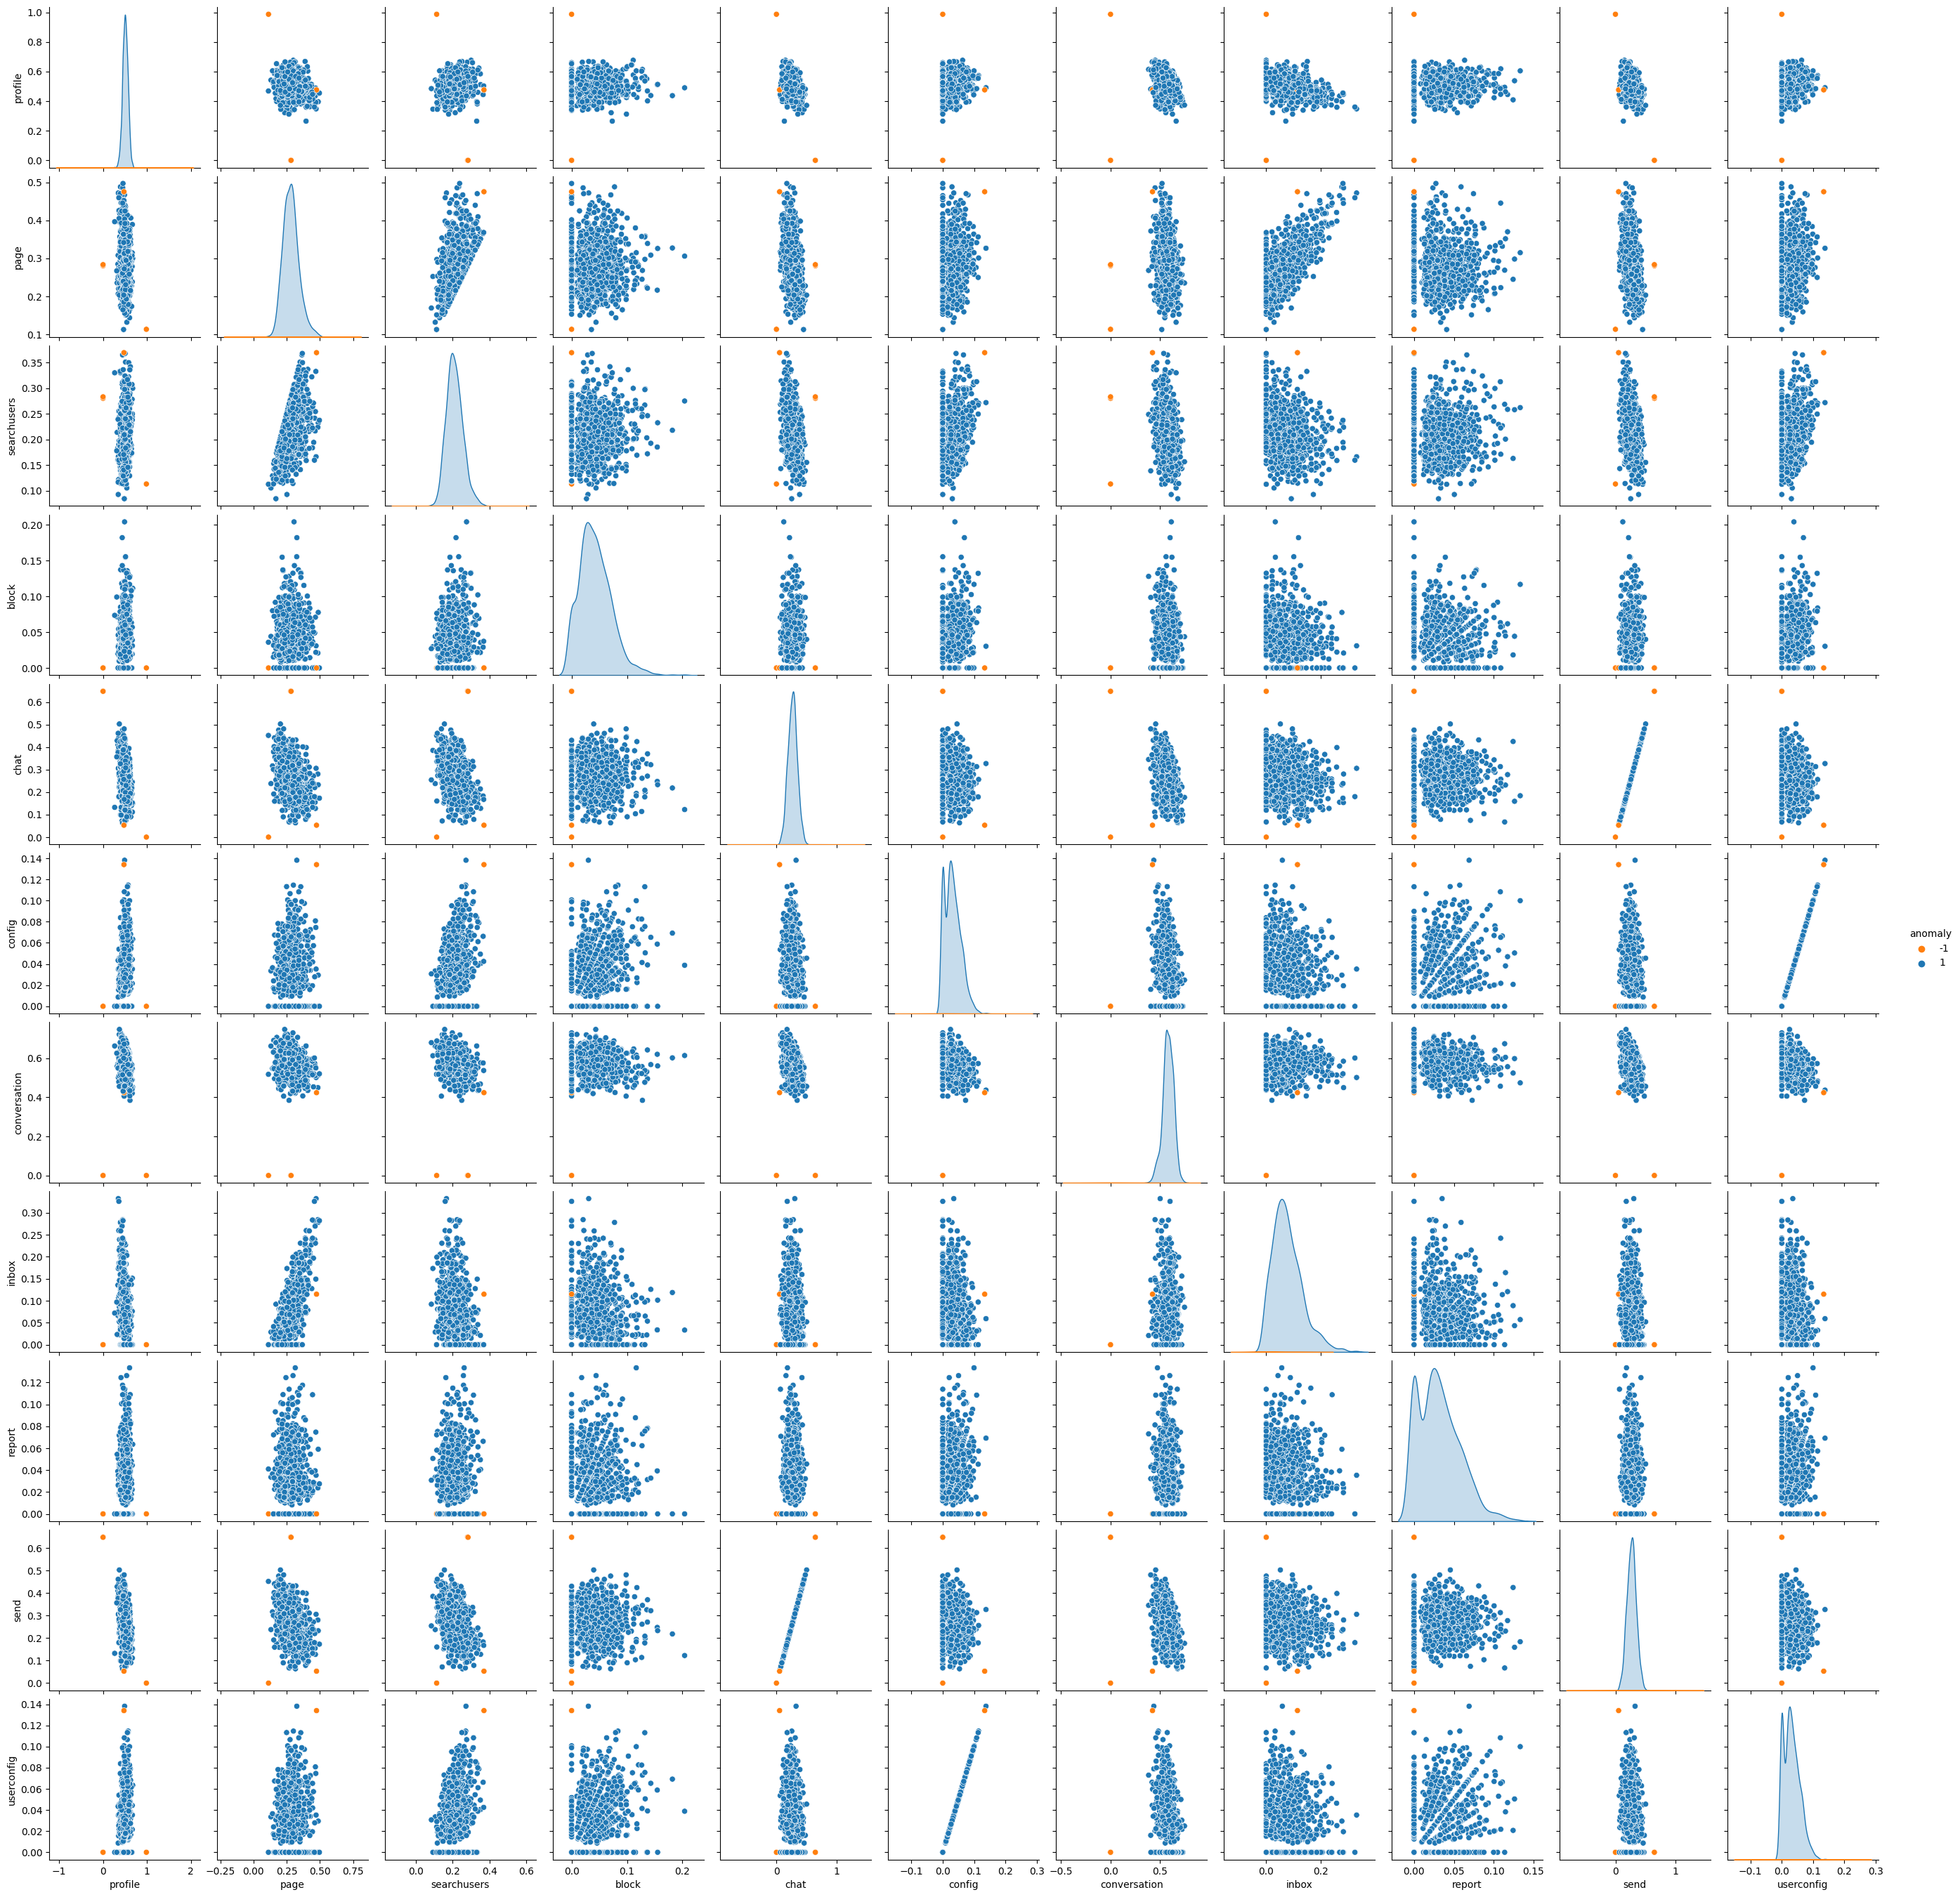

In [46]:
#Plots showcasing the outliers detected by isolation forest
palette = ['#ff7f0e', '#1f77b4']
sns.pairplot(df_tfidf_scores, vars=anomaly_inputs, hue='anomaly', palette=palette)


**Testing out TSNE**

In [ ]:
#Visualizing data with t-SNE
embedded_data = TSNE(perplexity=50.0, n_iter=2000).fit_transform(np.asarray(vect_logs.todense()))
spammer1 = embedded_data[5]
spammer2 = embedded_data[6]
dataScraper = embedded_data[7]

c:\Users\rosin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\rosin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


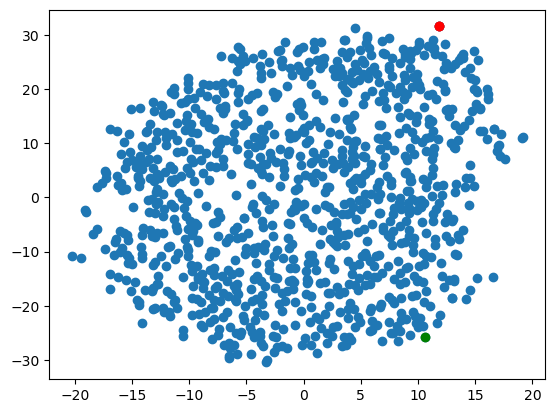

In [ ]:
plt.scatter(embedded_data[:,0], embedded_data[:,1])
plt.scatter(spammer1[0],spammer1[1], color='red')
plt.scatter(spammer2[0],spammer2[1], color='red')
plt.scatter(dataScraper[0],dataScraper[1], color='green')

**PCA: for dimension reduction**

In [ ]:
X = np.asarray(vect_logs.todense())
pca = PCA()
pc = pca.fit_transform(X)
pc = pd.DataFrame(pc)
print(pc.shape)
pc

(1004, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.014151,-0.056579,0.032928,-0.023269,0.055481,-0.034205,-0.040538,0.025775,-0.016518,0.009518,-1.280286e-16,-3.831713e-17,1.057929e-17,-2.338633e-18,-4.856402e-18
1,-0.004119,0.024946,-0.147911,-0.022661,0.028510,0.034089,-0.014530,0.004799,0.003663,-0.007788,-8.744214e-17,7.338508e-16,1.255754e-18,1.164123e-18,-1.868838e-18
2,-0.014892,-0.116458,-0.007735,0.021352,-0.046803,-0.034033,0.011968,0.011323,-0.003120,0.009117,-1.191586e-16,4.896034e-19,2.597761e-16,-8.735034e-18,5.820718e-19
3,0.053916,0.163665,-0.006286,0.058890,-0.023201,-0.003443,-0.069031,0.003830,0.044711,0.003305,-6.055011e-17,2.214700e-18,1.491026e-17,9.567101e-17,4.410390e-17
4,-0.117871,0.056486,-0.085556,-0.028776,0.044079,0.009919,-0.032389,0.033688,0.008695,0.033079,2.456695e-16,-6.957825e-18,1.102752e-18,4.682014e-18,-3.520608e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,-0.003835,0.099379,0.097485,0.005731,-0.050682,0.024302,-0.019628,0.004157,-0.008210,-0.023072,-1.329339e-16,4.575345e-19,-3.629689e-18,-1.301168e-18,3.277074e-19
1000,0.065047,0.050680,-0.043768,0.016372,-0.001074,-0.001450,0.013162,0.007790,-0.017865,-0.020936,-1.153172e-16,-8.995457e-19,-4.964431e-20,1.634690e-19,-6.660678e-19
1001,-0.146306,-0.000804,-0.094498,-0.031923,-0.004844,0.033087,0.017118,-0.003498,0.002426,-0.018177,-9.874414e-17,1.573456e-18,4.964509e-19,1.209640e-18,-1.029603e-18
1002,-0.020214,-0.117290,-0.037662,0.069434,-0.017167,0.054558,0.004377,-0.023142,-0.014244,0.004660,-1.185357e-16,-5.354122e-19,-5.627769e-20,-2.431543e-18,2.037926e-18


In [ ]:
print("Eigen values: ", list(np.round(pca.explained_variance_, decimals=5)))
print("PCA_variance_ratio: ", pca.explained_variance_ratio_)
print(pca.n_components)

Eigen values:  [0.01488, 0.00659, 0.0065, 0.0027, 0.00165, 0.00096, 0.00072, 0.00067, 0.00064, 0.00044, 0.0, 0.0, 0.0, 0.0, 0.0]
PCA_variance_ratio:  [4.16085399e-01 1.84349822e-01 1.81923581e-01 7.55255767e-02
 4.62256577e-02 2.67749579e-02 2.01896368e-02 1.87541698e-02
 1.79152153e-02 1.22559840e-02 3.65468573e-31 1.53534692e-32
 1.92533169e-33 4.23884406e-34 1.60565512e-34]
None


Following code just serves as a way to experiment using sequence of numbers. Could we use tfidf for vectorizing data?

In [ ]:
#Function to create a sequence of numbers. Approx. 10% of the sequences will consist of duplicates of the same number
import random

def create_sequence(arr, randVal):
    if (randVal < 1):
        val = random.randint(1,9)
        for i in range (50):
            arr.append(val)
    else:    
        for i in range (0, 50):
            arr.append(random.randint(1,9))
    return arr    

In [ ]:
#Function to give a sequence a score depending on number of consecutive duplicates
def sequence_evaluation(df):
    arr = []
    for i in range (0, df.shape[0]):
        data = df.iloc[i].to_list()
        score = 0
        lr = 0.1
        val = data[0]
        for j in range (1, len(data)):
            if (data[j] == val):
                score -= lr*data[j]
                if(lr < 1):
                    lr += 1.1*lr
            else:
                score += data[j]
                val = data[j]
        arr.append(score) 
    return arr     

In [ ]:
#Function that calculates length of the longest subsequence of consecutive duplicates for each sequence
from itertools import groupby

def longestConsecutive(df):
    arr = []
    for i in range (0, df.shape[0]):
        longest_streak = len(max([list(group) for _, group in groupby(df.iloc[i].to_list())], key=len))
        arr.append(longest_streak)
    return arr

In [ ]:
#Creation of the sequence data frame
sequence_matrix = []
for i in range (1000):
    randVal = random.randint(0,9)
    arr = []
    sequence_matrix.append(create_sequence(arr, randVal))

sequence_df = pd.DataFrame(sequence_matrix)

sequence_df['score'] = sequence_evaluation(sequence_df)
sequence_df['longestConsec'] = longestConsecutive(sequence_df.loc[:, sequence_df.columns != 'score'])
sequence_df

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,score,longestConsec
0,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,-178.38710,50
1,7,2,1,4,2,3,2,5,4,6,...,2,2,5,1,9,8,9,5,123.78208,3
2,8,5,8,4,2,4,5,3,6,4,...,3,2,2,7,3,3,6,2,114.16310,3
3,5,1,7,8,9,6,4,1,4,1,...,8,6,9,3,4,2,9,3,203.39200,3
4,4,9,9,4,7,8,7,2,7,1,...,8,9,7,4,5,3,3,2,201.97204,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,8,6,3,3,3,6,9,9,5,...,5,4,5,7,1,6,4,2,195.32270,3
996,6,4,2,7,7,9,6,6,5,4,...,8,3,9,5,5,7,5,6,174.57170,2
997,1,8,6,3,7,4,7,8,4,1,...,2,9,4,8,8,2,2,2,105.54615,6
998,3,2,7,1,7,6,1,8,2,8,...,1,7,5,9,1,8,4,7,206.38500,2


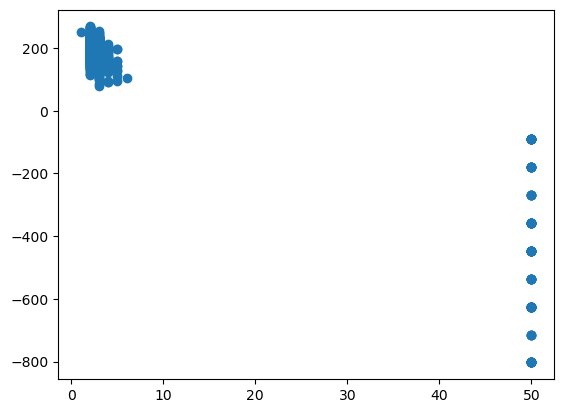

In [ ]:
#A yanky scatter plot....
plt.scatter(sequence_df['longestConsec'], sequence_df['score'])